จากใน ep ก่อน ๆ ที่เราได้นำ [Callback มาประยุกต์ใช้ใน Training Loop](https://www.bualabs.com/archives/2348/how-to-apply-callback-in-training-loop-neural-network-flexible-neural-network-ep-10/) เพื่อช่วยให้การเทรนมีความยืดหยุ่น แต่ติดข้อจำกัดว่าเราไม่สามารถเข้าถึงข้อมูลภายในโมเดล ในแต่ละ Layer ได้ เนื่องจากการสร้างโมเดลของเราเป็นการเรียกใช้ API ของ PyTorch

ใน ep นี้ เราจะเจาะลึกเข้าไปในโมเดล Convolutional Neural Network เข้าไปถึงข้อมูล การทำงานในแต่ละ Layer ด้วยโมเดลพิเศษที่เราสร้างขึ้นมาเอง เปรียบเทียบกับการใช้กลไก Hook ของ PyTorch เราจะเริ่มต้นที่หัวข้อ [4. Model](#4.-Model)

# 0. Magic

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

In [0]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
import fastai
from fastai import datasets
from fastai.metrics import accuracy
from fastai.basic_data import *
from fastai.basic_train import *
import pickle, gzip, math, torch, re
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from functools import partial

# 2. Data

In [0]:
class Dataset(Dataset):
    def __init__(self, x, y, c):
        self.x, self.y, self.c = x, y, c
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

# 3. Data Preprocessing

In [0]:
def normalize(x, m, s): 
    return (x-m)/s

In [0]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [0]:
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()   

In [0]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [0]:
bs = 128
n, m = x_train.shape
c = (y_train.max()+1).numpy()
loss_func = F.cross_entropy

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train, c), Dataset(x_valid, y_valid, c)
# train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

In [0]:
data = DataBunch.create(train_ds, valid_ds, bs=bs, num_workers=8)

# 4. Model

เราจะใช้โมเดล [Sequential ที่เราสร้างเอง](https://www.bualabs.com/archives/2042/refactor-parameter-optimizer-neural-network-train-deep-learning-machine-learning-neural-network-ep-6/) แทนที่จะใช้ nn.Sequential ของ PyTorch เพื่อที่เราจะได้แทรกโค้ด ใน \_\_call\_\_() เก็บสถิติ Mean, Standard Deviation ของแต่ละ Layer ไว้ทุก Mini-Batch

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
        
    def __iter__(self): return iter(self.layers)

def get_cnn_model(data):
    return SequentialModel(
        # Lambda(mnist_resize),  # use BatchTransformXCallback instead.
        nn.Conv2d(  1,  8, 5, padding=2, stride=2), nn.ReLU(), #14
        nn.Conv2d(  8, 16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d( 16, 32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d( 32, 32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1), 
        Lambda(flatten), 
        nn.Linear(32, data.c)
    )

วิธีการเทรน Callback, Training Loop เหมือนปกติ เริ่มเทรนใน [หัวข้อ 7. Train](#7.-Train)

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x): return self.func(x)

In [0]:
def flatten(x): return x.view(x.shape[0], -1)
# def mnist_resize(x): return x.view(-1, 1, 28, 28) # use BatchTransformXCallback instead.

# 5. Training Loop

แล้วเราจะเทรนตามปกติ

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()]+cbs

    @property
    def opt_func(self):     return self.learn.opt_func
    @property
    def model(self):        return self.learn.model
    @property
    def loss_func(self):    return self.learn.loss_func
    @property
    def data(self):         return self.learn.data

    def one_batch(self, xb, yb):
        try: 
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt_func.step()
            self('after_step')
            self.opt_func.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
    
    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl:
                self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
    
    def fit(self, epochs, learn):
        self.epochs, self.learn, self.loss = epochs, learn, tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
        except CancelTrainException: self('after_cancel_train')
        finally: 
            self('after_fit')
            self.train = None

    def __call__(self, cb_name):
        # return True = Cancel, return False = Continue (Default)
        res = False
        # check if at least one True return True
        for cb in sorted(self.cbs, key=lambda x: x._order): res = res or cb(cb_name)
        return res        

# 6. Callbacks

In [0]:
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
    
    def begin_epoch(self):
        self.run.n_epochs = self.epoch  
        self.model.train()
        self.run.in_train=True

    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False    
           
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [0]:
class Recorder(Callback):
    def begin_fit(self): 
        self.lrs = [[] for _ in self.opt_func.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt_func.param_groups, self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr(self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [0]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

class AvgStats():
    def __init__(self, metrics, in_train): 
        self.metrics, self.in_train = listify(metrics), in_train
    
    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn


In [0]:
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs): self.pname, self.sched_funcs = pname, sched_funcs

    def begin_fit(self): 
        if not isinstance(self.sched_funcs, (list, tuple)): 
            self.sched_funcs = [self.sched_funcs] * len(self.opt_func.param_groups)

    def set_param(self):
        assert len(self.opt_func.param_groups) == len(self.sched_funcs)
        for pg, f in zip(self.opt_func.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)

    def begin_batch(self):
        if self.in_train: self.set_param()

In [0]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner 

In [0]:
@annealer
def sched_lin(start, end, pos): return start + pos * (end - start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

In [0]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [0]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)

    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner    

In [0]:
max_lr = 3e-1
sched = combine_scheds([0.3, 0.7], [sched_cos(3e-3, max_lr), sched_cos(max_lr, 3e-4)])

In [0]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()


เพื่อความยืดหยุ่น เราจะใช้ Callback ในการแปลง MNIST ที่มาในรูปแบบ Matrix 2 มิติ ให้เป็น 4 มิติตามที่โมเดลต้องการ แทนที่จะ Fix เป็น Layer ภายในโมเดล 

In [0]:
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): 
        # set_trace()
        self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    # set_trace()
    def _inner(x): return x.view(*(-1, )+size)
    return _inner


In [0]:
mnist_view = view_tfm(1, 28, 28)

ในเคสนี้ เราจะไม่ใช้ ParamScheduler จะได้เห็นชัด ๆ

In [0]:
# cbfs = [Recorder, CudaCallback, partial(ParamScheduler, 'lr', sched), partial(BatchTransformXCallback, mnist_view), partial(AvgStatsCallback, accuracy)]
cbfs = [Recorder, CudaCallback, partial(BatchTransformXCallback, mnist_view), partial(AvgStatsCallback, accuracy)]

# 7. Train

เริ่มต้นเทรน ด้วย SGD ใช้ GPU ด้วย จะได้เทรนเร็ว ๆ

In [0]:
device = torch.device('cuda',0)
torch.cuda.set_device(device)
fastai.torch_core.defaults.device = device

In [0]:
model = get_cnn_model(data)

opt = torch.optim.SGD(model.parameters(), lr=max_lr)
learn = Learner(data, model, opt, loss_func=loss_func)

run = Runner(cb_funcs=cbfs)


เทรนไป 1 Epoch ก็พอ เนื่องจากเราต้องการจะดู Activation Map ของแต่ละ Layer เท่านั้น

In [34]:
%time run.fit(1, learn)

train: [0.8609860151241987, tensor(0.6986, device='cuda:0')]
valid: [0.150163037109375, tensor(0.9547, device='cuda:0')]
CPU times: user 5.28 s, sys: 1.31 s, total: 6.59 s
Wall time: 6.34 s


# 8. Interpret

พล็อต Loss

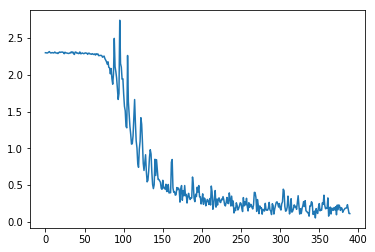

In [36]:
run.recorder.plot_loss()

เราลองพล็อตกราฟ Mean ของแต่ละ Activation Map ตลอดการเทรน 1 Epoch

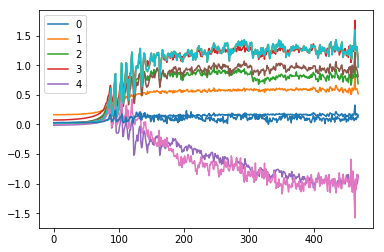

In [38]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5))

เราลองพล็อตกราฟ Standard Deviation ของแต่ละ Activation Map ตลอดการเทรน 1 Epoch

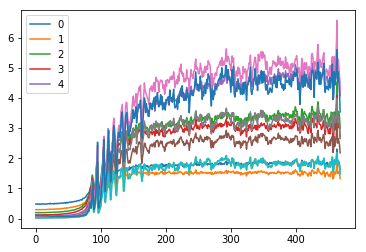

In [39]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5))

เราจะซูมเข้าไปดู 10 Iteration แรก

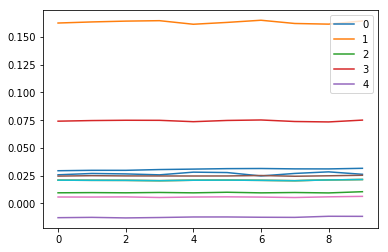

In [40]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5))

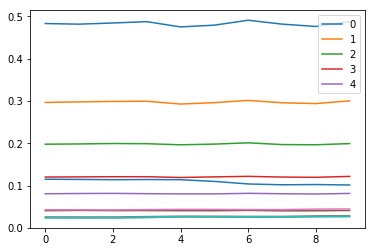

In [41]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5))

# 4/2. Model nn.Sequential

เราจะเปลี่ยนกลับมาสร้างโมเดล ด้วย nn.Sequential เหมือนเดิม แล้วใช้ Hook ของ PyTorch ในการดูภายในโมเดล แทนที่การเก็บข้อมูลแบบ Manual ด้านบน

In [0]:
model = nn.Sequential(
        # Lambda(mnist_resize),  # use BatchTransformXCallback instead.
        nn.Conv2d(  1,  8, 5, padding=2, stride=2), nn.ReLU(), #14
        nn.Conv2d(  8, 16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d( 16, 32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d( 32, 32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1), 
        Lambda(flatten), 
        nn.Linear(32, data.c)
    )

# 6/2. PyTorch Hook

ประกาศตัวแปร เอาไว้เก็บสถิติภายในโมเดล

In [0]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

ประกาศฟังก์ชัน เอาไว้ให้ Hook เรียก เพื่อเก็บสถิติภายในโมเดล ฟังก์ชัน Callback/Hook นี้จะมี Parameter 3 ตัวคือ Module, Input และ Output

In [0]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

Register Hook เข้ากับ การทำงานขา Forward ของ ทุก ๆ Layer ภายในโมเดล  

In [0]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

# 7/2. Train

สั่งเทรนตามปกติ

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=max_lr)
learn = Learner(data, model, opt, loss_func=loss_func)

run = Runner(cb_funcs=cbfs)

In [47]:
run.fit(1, learn)

train: [0.7218699137369792, tensor(0.7613, device='cuda:0')]
valid: [0.142701806640625, tensor(0.9591, device='cuda:0')]


# 8/2. Interpret

พล็อต Loss

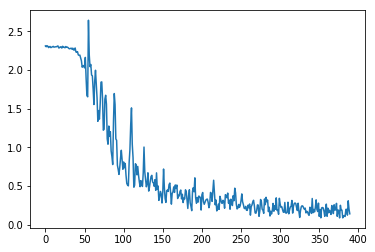

In [52]:
run.recorder.plot_loss()

พล็อตกราฟ ดูค่าเฉลี่ยของ Activation Map ใน Layer ต่าง ๆ ที่เราเก็บจาก Hook

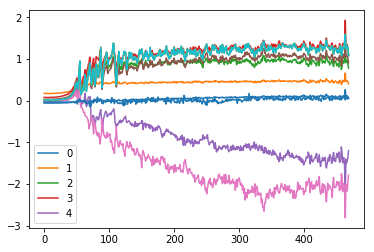

In [48]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

พล็อตกราฟ ดูค่า Standard Deviation ของ Activation Map ใน Layer ต่าง ๆ ที่เราเก็บจาก Hook

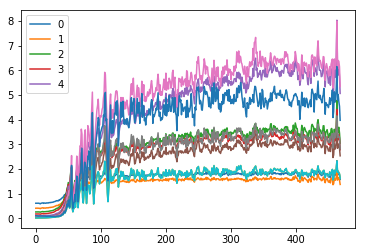

In [49]:
for o in act_stds: plt.plot(o)
plt.legend(range(5))

เราจะซูมเข้าไปดู 10 Iteration แรก

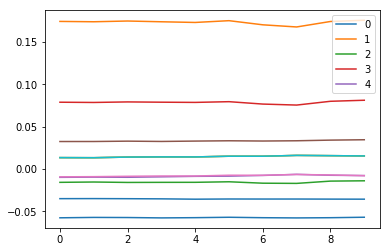

In [50]:
for l in act_means: plt.plot(l[:10])
plt.legend(range(5))

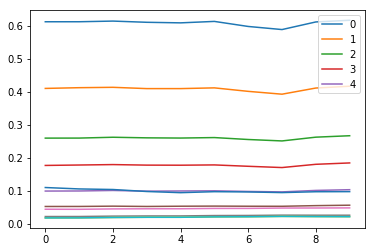

In [51]:
for l in act_stds: plt.plot(l[:10])
plt.legend(range(5))

เราได้กราฟจาก Hook หน้าตาเหมือนกับ ที่เราเก็บสถิติ แบบ Manual แสดงว่าทำงานถูกต้องตรงกัน

# 9. สรุป

* เราได้เรียนรู้การใช้ Hook ในการเจาะลึกเข้าไปดูภายใน Deep Neural Network Model
* เราได้เก็บข้อมูล Activation Map ของแต่ละ Layer ตลอดการเทรน มาพล็อตเป็นกราฟ เพื่อวิเคราะห์
* กราฟในช่วงประมาณ 100 Iteration แรก แตกต่างกับช่วงหลังที่โมเดล เริ่มเทรนเข้าที่ ส่งผลให้ Loss ลดลงอย่างรวดเร็ว อะไรทำให้เกิด 100 Iteration แรกนั้น เราจะทำให้มันสั้นลง หรือไม่เกิดเลยได้หรือไม่
* กราฟที่ได้ ค่อนข้างคลาดเคลื่อนไปจาก Mean=0, Standard Deviation=1 ที่เราคาดหวังว่าจะให้ผลการเทรนดีที่สุด ค่อนข้างมาก เราจะแก้ปัญหานี้อย่างไร

# Credit

* https://course.fast.ai/videos/?lesson=10
* http://yann.lecun.com/exdb/mnist/